# Ideas
- Use DummyClassifier
- Create Confusion Matrix
- Use clustering method to categorize. Use k-medoids for categorical data. Use k-means for continuous data.

In [1]:
from platform import python_version
print(python_version())

3.6.5


# Main funct

In [2]:
debug=False

import knn_impute_Py3 as knn_impute
import pandas as pd

from pandas.api.types import CategoricalDtype

pd.options.mode.chained_assignment = 'warn' #'raise' shows what line throws warning

#from pandas.tools.plotting import scatter_matrix
#from pandas.tools.plotting import andrews_curves
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#ignore certain warnings
import warnings
warnings.filterwarnings("ignore", message="Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.")

#increase screen width
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:55% !important; }</style>"))

import socket #for .gethostname()

def UserFolder():
    return 'jkang1' if socket.gethostname()=='RADONC67DT' else 'John'

def ConvertToNumeric(df):
    # put the original column names in a python list
    original_headers = list(df.columns.values)

    # remove the non-numeric columns
    df = df._get_numeric_data()  
    
    # put the numeric column names in a python list
    numeric_headers = list(df.columns.values)

    # create a numpy array ConvertInputwith the numeric values for input into scikit-learn
    numpy_array = df.as_matrix()
    
    display(numeric_headers, numpy_array)
    
    return numeric_headers, numpy_array
    
def DropColumns(df):
    
    #PRE-PROCESSING: drop unnecessary columns 

    #drop columns that are PHI (names, birthdates), redundant (variables with "complete"), or are free text (f2 biopsy variables)
    df = df.drop(['f1_urol_pt_name', 'f1_last_name','f1_first_name', 'f1_medrec', 'f1_birthdate' ,'f1_race', 'demographics_complete'], axis=1, errors='ignore')
    df = df.drop(['f2_info_lbase','f2_info_lmid','f2_info_lapex','f2_info_rbase','f2_info_rmid','f2_info_rapex','f2_additiona_bx_info','f2_core_other_specify','prerp_staging_complete'], axis=1, errors='ignore')
    df = df.drop(['adjuvant_treatment_complete','biochemical_failure_outcomes_complete', 'rp_pathologic_features_complete'], axis=1, errors='ignore')

    ## PRE-PROCESSING: Remove adjuvant/salvage, zero and NaN columns

    #drop columns for adjuvant treatment data
    df.drop([col for col in df.columns if "f4" in col], axis=1, inplace=True)

    #drop columns for salvage treatment data
    df.drop([col for col in df.columns if "f5" in col], axis=1, inplace=True)

    #drop columns that are all zero
    df.loc[~(df==0).all(axis='columns')]

    #which columns are zero
    #df.apply(lambda x: np.all(x==0))

    #drop columns that are all "not a number"
    df.dropna(axis='columns',how='all');

    #drop columns that are not informative
    df = df.drop(['f1_ecog_preprostatect'], axis=1, errors='ignore')

    return df

def DropDateColumns(df):
    return df.drop([col for col in df.columns if 'date' in col], axis='columns')

def MakeUpper(df):
    #Make all cells uppercase
    return df.applymap(lambda x: x.upper() if type(x)==str else x)

def ConvertRace(df):  
    #Convert imported races to final 4 categories: Unknown, Black, Asian, White
    lookup = {"f1_race_imported": {"** NO DESCRIPTION **": "UNKNOWN",
                                   "african american":"BLACK",
                                   "AFRICAN AMERICAN":"BLACK",
                                   "AMERICAN INDIAN OR ALASKA NATI":"UNKNOWN",
                                   "ASIAN INDIAN":"ASIAN",
                                   "black":"BLACK",
                                   "BLACK OR AFRICAN AMERICAN": "BLACK",
                                   "black/african":"BLACK",
                                   "Black/African American":"BLACK",
                                   "BLACK/AFRICAN":"BLACK",
                                   "BLACK/AFRICAN AMERICAN":"BLACK",
                                   "OTHER":"UNKNOWN",
                                   "PATIENT DECLINED":"UNKNOWN",
                                   "TAHITIAN":"ASIAN",
                                   "unknown":"UNKNOWN",
                                   "white":"WHITE"}}
    #df['f1_race_imported'] = df['f1_race_imported'].astype(CategoricalDtype(ordered=False))
    return df.replace(to_replace=lookup, value=None)

def SetCategorical(df):
    
    #[cols for cols in df.columns if 'gleason' in cols]
    ['f1_urologist',
     'f2_prerp_gleason',
     'f2_gleason_lbase',
     'f2_gleason_lmid',
     'f2_gleason_lapex',
     'f2_gleason_rbase',
     'f2_gleason_rmid',
     'f2_gleason_rapex',
     'f2_gleason_other',
     'f3_rp_gleason']
    
    for col in ['f1_race_imported']:
        df[col] = df[col].astype(CategoricalDtype(ordered=False)) 
    
    return df
    
def ReplaceText(df):
     #Replace improper free text
    lookup = {np.nan:None,
             '0':0,
             '1/5 CORES':20,
             '3/5 CORES':60,
             '5%':5,
             '30%':30,
             '30?':30,
             '33%':33,
             '35%':35,
             '95%':95,
             '778':78, #confirmed for record_id = 40
             '<1': 0.5,
             '<2': 1,
             '<5': 2.5,
             '<10': 5,
             '<5-10': 7.5,
             '<25': 12.5,
             '15-20': 17.5,
             '15-25':20,
             '25-30': 27.5,
             '20-30': 25,
             '25-35': 30,
             '30-50':40,
             '35-40':37.5,
             '40-50': 45,
             '60-70': 65,
             '70-80': 75,
             '75-80': 77.5,
             '80-90': 85,
             '85-90': 87.5,
             '>50': 75,
             '>70': 85,
             '>95': 97.5,
             '2-JAN':1.5,
             '10-MAY':7.5,
             '8-MAY': 6.5,
             '15-OCT': 12.5,
             '20-OCT' : 15}
    return df.replace(lookup,value=None)
    
def SetNumeric(df):
    """
    #Second convert to numeric
    cols =  ['f2_prost_volume_bx',
             'f2_total_bx_cores',
             'f2_positive_bx_cores',
             'f2_negative_bx_cores',
             'f2_calc_percent_pos',
             'f2_percent_lbase_pos',
             'f2_percent_lmid_pos',
             'f2_percent_lapex_pos',
             'f2_percent_rbase_pos',
             'f2_percent_rmid_pos',
             'f2_percent_rapex_pos',
             'f2_percent_other_pos']
  
    df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')
    """
    return df

def SetPNI_PIN(df):
    #cols = [col for col in df.columns if ('pos' in col) & ('pni' in col)]
    cols=['f2_pni_lbase_pos',
         'f2_pni_lmid_pos',
         'f2_pni_lapex_pos',
         'f2_pni_rbase_pos',
         'f2_pni_rmid_pos',
         'f2_pni_rapex_pos',
         'f2_pni_other_pos',
         'f2_pin_lbase_pos',
         'f2_pin_lmid_pos',
         'f2_pin_lapex_pos',
         'f2_pin_rbase_pos',
         'f2_pin_rmid_pos',
         'f2_pin_rapex_pos',
         'f2_pin_other_pos']

    df[cols]=df[cols].replace({3:None, np.nan:None})
    return df

def SetPSA(df):
    
    cols = ['f2_psa1_pre_bx',
         'f2_psa2_pre_rp',
         'f2_psa3_pre_rp',
         'f2_psa4_pre_rp',
         'f3_rp_psa_nadir_value']
    
    df[cols] = df[cols].applymap(lambda x: x.split('>')[1] if '>' in x else x) #if >X, set to X
    df[cols] = df[cols].applymap(lambda x: pd.to_numeric(x.split('<')[1])/2 if '<' in x else x) #if <X, set to X/2
    
    df[cols] = df[cols].replace({"'UNDETECTABLE'":0, 'UNDETECTABLE':0,
                                 "'NORMAL'": 3, '6.37\\':6.37, "'UNDER 4'":2, '~3':3})
    #df[cols]=df[cols].applymap(lambda x: '0' if x=="'UNDETECTABLE'" or x=='UNDETECTABLE'  else x)    
    return df


def DatasetSummary(df):
    pd.options.display.max_rows = 200

    display(pd.DataFrame(data=pd.concat( [df.apply(lambda x: len(x.unique())), df.dtypes], axis=1))
           .rename(columns={0:'unique',1:'dtype'}))
    display(df.describe())
    

def PrintUnique(df, keyword=''):
    print('\nUnique values: \n')
    [print(col, df[col].unique(),'\n') for col in df.columns if keyword in col]
        

def ListOutcomes(mdl_var):
    if 'MSK' in mdl_var:
        return ['f3_rp_tstage', 'f3_rp_epe','f3_rp_svi','f3_rp_nstage']
    else:
        return ['f3_rp_tstage', 'f3_rp_epe','f3_rp_svi','f3_rp_nstage'] #plan to add more

def ListInputs(mdl_var=''):
    if 'MSK' in mdl_var:
        return ['f2_psa1_pre_bx','f2_prerp_gleason4+3','f2_prerp_gleason3+4',
                'f2_ct_stage2A', 'f2_ct_stage2B', 'f2_ct_stage2C', 'f2_ct_stage3+',
                'f2_negative_bx_cores', 'f2_positive_bx_cores']
    elif 'RF' in mdl_var:
        return ['f1_calc_age_prostatect', 'f1_race_imported',
               'f2_psa1_pre_bx', 'f2_prerp_gleason4+3', 'f2_prerp_gleason3+4',
               'f2_ct_stage2A', 'f2_ct_stage2B', 'f2_ct_stage2C', 'f2_ct_stage3+',
               'f2_negative_bx_cores', 'f2_positive_bx_cores', 'f2_locat_bx_cores___1',
               'f2_locat_bx_cores___2', 'f2_locat_bx_cores___3',
               'f2_locat_bx_cores___4', 'f2_locat_bx_cores___5',
               'f2_locat_bx_cores___6', 'f2_locat_bx_cores___7', 'f2_gleason_lbase',
               'f2_percent_lbase_pos', 'f2_pni_lbase_pos', 'f2_pin_lbase_pos',
               'f2_gleason_lmid', 'f2_percent_lmid_pos', 'f2_pni_lmid_pos',
               'f2_pin_lmid_pos', 'f2_gleason_lapex', 'f2_percent_lapex_pos',
               'f2_pni_lapex_pos', 'f2_pin_lapex_pos', 'f2_gleason_rbase',
               'f2_percent_rbase_pos', 'f2_pni_rbase_pos', 'f2_pin_rbase_pos',
               'f2_gleason_rmid', 'f2_percent_rmid_pos', 'f2_pni_rmid_pos',
               'f2_pin_rmid_pos', 'f2_gleason_rapex', 'f2_percent_rapex_pos',
               'f2_pni_rapex_pos', 'f2_pin_rapex_pos', 'f2_core_other___1',
               'f2_core_other___2', 'f2_core_other___3', 'f2_gleason_other',
               'f2_percent_other_pos', 'f2_pni_other_pos', 'f2_pin_other_pos',
               'f2_tertiary_score', 'f2_pni_number_cores', 'f2_calc_percent_pni',
               'f2_pin_number_cores', 'f2_calc_percent_pin', 'f2_pre_androgen_tx',
               'f2_intermed_factors', 'f2_fav_or_unfav']
    elif mdl_var is '':
        return [col for col in df.columns if 'f2' in col]

def InputsOnly(df):
    return df.loc[:, [col for col in df.columns if ('f1' in col) or ('f2' in col)]]

def OutputsOnly(df):
    return df.loc[:,[col for col in df.columns in 'f3' in col]]

def GetDictValues(key):
    if 'f2_prerp_gleason' in key:
        return {1:'3+3',2:'3+4',3:'4+3'}
    elif 'f2_ct_stage' in key:
        return {1:'cT1',2:'cT1c',3:'cT2',4:'cT2a',5:'cT2b',6:'cT2c',7:'unk'}
    elif 'f3_rp_tstage' df_inin key:
        return {1:'pT2', 2:'pT2a', 3:'pT2b', 4:'pT2c', 5:'pT3', 6:'pT3a', 7:'pT3b', 8:'pT4'}
    elif 'f3_rp_svi' in key:
        return {1:'Yes', 2:'No', 3:'Unk'}
    elif 'f3_rp_nstage' in key:
        return {1:'pN0', 2:'pN1', 3:'pNx'}
    elif 'f3_rp_epe' in key:
        return {1:'Yes', 2:'No', 3:'Unk'}
    else:
        return key

def ImputeDataFrame(df, strategy='median'):
    from sklearn.preprocessing import Imputer

    imp = (Imputer(missing_values='NaN', strategy=strategy, axis=0)
           .fit(df))
    output = pd.DataFrame(data = imp.transform(df), columns=df.columns, index=df.index)
    return output

def HandleMissingData(df, impute=False, strategy='median'):
    if impute is True: #impute instances with any nan
        df = ImputeDataFrame(df,strategy=strategy)
    else: #remove any instances with nan in any column
        df = df.dropna(axis='rows',how='any')
    return df

def GetFeatureDict(file='feat_OHE_dict.csv'):
    feat_dict = pd.read_csv(file, index_col='feat_OHE').to_dict()['full_name']
    return feat_dict


In [3]:
import sklearn
display(pd.__version__,
        np.__version__,
        sklearn.__version__)

'0.23.0'

'1.14.3'

'0.20.1'

# Preprocess funct

__To do__

[x] Combine L and R sides

In [4]:
def PreProcess(df_raw, mdl_name, mdl_var, IO='IO'): 
    #Inputs: raw dataframe, 
    
    def SelectInputs(df, mdl_var):
    #Inputs: raw DataFrame df, variable selector mdl_var
    #Output: dataframe of necessary input variables extracted per specifications of variable selector mdl_var

        if 'MSK' in mdl_var:
            """
            Inputs: age, pre-biopsy PSA, 1’ Gleason, 2’ Gleason, T-stage (T1a-T3c), No. +cores, No. -cores 
            Model type: multivariate logistic regression
            Outputs: 
                primary treatment: CSS (prostate deaths), PFS (PSA <0.05 ng/mL)
                extent of disease: OCD (Pathologic upstage), EPE/ECE, LN+, SVI+
            Notes: needs core bx info but can predict 1' treatment outdfomes in addition to extent of disease
            """
            #use columns required to calculate Kattan-type nomogram on https://www.mskcc.org/nomograms/prostate/pre_op
            cols = ['f2_psa1_pre_bx','f2_prerp_gleason','f2_ct_stage', 'f2_positive_bx_cores', 'f2_total_bx_cores']

            #convert all columns to numeric ({'unknown':nan})
            df = df.loc[:,cols].apply(pd.to_numeric, errors='coerce')

            #caclulate no. negative cores and remove total no. cores because not used in MSK model
            df['f2_negative_bx_cores'] = df['f2_total_bx_cores']-df['f2_positive_bx_cores']
            df.drop('f2_total_bx_cores',axis='columns',inplace=True)
            return df
        
        elif 'RF' in mdl_var:
            cols_rgn = [col for col in df.columns if ('f1_race_imported' in col)
                        or ('f1_calc_age_prostatect' in col) 
                        or ('f2_locat_bx_cores' in col) 
                        or ('f2_gleason' in col)
                        or ('f2_percent' in col)
                        or ('f2_pni' in col)
                        or ('f2_pin' in col)
                        or ('f2_core_other__' in col)
                        or ('f2_tertiary_score' in col)
                        or ('f2_pni_number_cores' in col)
                        or ('f2_calc_percent_pni' in col)
                        or ('f2_calc_percent_pin' in col)
                        or ('f2_fav_or_unfav' in col)
                        or ('f2_pre_androgen_tx' in col)
                        or ('f2_intermed_factors') in col]
            return df[cols_rgn]
        
            """
            df = DropColumns(df)
            df = DropDateColumns(df)
            df = ConvertRace(df)
            df = MakeUpper(df)
            df = SetCategorical(df)
            df = SetNumeric(df)
            df = SetPNI_PIN(df)
            df = SetPSA(df)
            """

    def SelectOutputs(df, mdl_var):
    #Inputs: raw DataFrame df, variable selector mdl_var
    #Output: dataframe of necessary output variables extracted per specifications of variable selector mdl_var

        if ('MSK' in mdl_var) or ('RF' in mdl_var):
            output = df.loc[:,['f3_rp_tstage','f3_rp_svi','f3_rp_nstage','f3_rp_epe']]
            print('Summary statistics for outcomes: ',
                  '\npT3+:', sum(df['f3_rp_tstage'] >= 5) / len(df['f3_rp_tstage']), '; Organ confined disease: ', sum(df['f3_rp_tstage'] < 5) / len(df['f3_rp_tstage']) ,
                  '\nEPE: ', sum(df['f3_rp_epe']==1)/( sum(df['f3_rp_epe']==1)+ sum(df['f3_rp_epe']==2)),
                  '\nSVI: ', sum(df['f3_rp_svi']==1)/( sum(df['f3_rp_svi']==1)+ sum(df['f3_rp_svi']==2)),
                  '\npN+: ', sum(df['f3_rp_nstage']==2)/( sum(df['f3_rp_nstage']==1) + sum(df['f3_rp_nstage']==2))) 
            display('Value counts: ', output.apply(pd.value_counts, sort=True, dropna=False).sort_index()) if debug else ''

            #None-MSK vars
            #df['PNI'] = (1:Yes, 2: No, 3: Unknown)
            #df['SM'] = (1: Yes, 2: No, 3: Unkown)
        return output
    
    def FormatInput(df,mdl_var):
        #Converts input to mdl_var format

        if 'MSK' in mdl_var: #use whole data set. Do NOT use train_test_split
            #Create variables denoting MSK beta coefficients
            return pd.DataFrame({'f2_psa1_pre_bx': df.loc[:,'f2_psa1_pre_bx'],
                               'f2_prerp_gleason4+3': df.loc[:,'f2_prerp_gleason']==3,
                               'f2_prerp_gleason3+4':  df.loc[:,'f2_prerp_gleason']==2,
                               'f2_ct_stage2A': df.loc[:,'f2_ct_stage']==4,
                               'f2_ct_stage2B': df.loc[:,'f2_ct_stage']==5,
                               'f2_ct_stage2C': df.loc[:,'f2_ct_stage']==6,
                               'f2_ct_stage3+': np.zeros( df.shape[0]),
                               'f2_negative_bx_cores': df.loc[:,'f2_negative_bx_cores'],
                               'f2_positive_bx_cores': df.loc[:,'f2_positive_bx_cores']})
        elif 'RF' in mdl_var:
            
            #One hot encoding for race
            df = pd.get_dummies(ConvertRace(df), columns=['f1_race_imported'])
            
            return df.apply(pd.to_numeric, errors='coerce')
            
        else:
            return df
        
    def FormatOutput(df,mdl_var):
        if ('MSK' in mdl_var) or ('RF' in mdl_var):
            df2 = df.copy()
            df2.loc[ df['f3_rp_tstage']< 5, 'f3_rp_tstage'] = 1
            df2.loc[ df['f3_rp_tstage']>=5, 'f3_rp_tstage'] = 0

            df2.loc[ df['f3_rp_svi']==1, 'f3_rp_svi'] = 1
            df2.loc[ df['f3_rp_svi']==2, 'f3_rp_svi'] = 0
            df2.loc[ df['f3_rp_svi']==3, 'f3_rp_svi'] = None

            df2.loc[ df['f3_rp_nstage']==1, 'f3_rp_nstage'] = 0
            df2.loc[ df['f3_rp_nstage']==2, 'f3_rp_nstage'] = 1
            df2.loc[ df['f3_rp_nstage']==3, 'f3_rp_nstage'] = None

            df2.loc[ df['f3_rp_epe']==1, 'f3_rp_epe'] = 1
            df2.loc[ df['f3_rp_epe']==2, 'f3_rp_epe'] = 0
            df2.loc[ df['f3_rp_epe']==3, 'f3_rp_epe'] = None
            return df2
        else:
            return df

    #Make all strings uppercase and replace  free text with closest approximations
    df = ReplaceText(MakeUpper(df_raw))
    #df = MakeUpper(df_raw)
    #df = df_raw
    
    #select necessary variables from raw dataframe per variable selector mdl_var
    X = SelectInputs(df,mdl_var)
    Y = SelectOutputs(df,mdl_var)

    #convert into dataframe compatible per variable selector mdl_var
    X = FormatInput(X, mdl_var)
    Y = FormatOutput(Y, mdl_var)

    if IO == 'IO':    
        return pd.concat([X,Y], axis='columns')
    elif IO=='I':
        return X
    elif IO=='O':
        return Y
    else:
        return 'Error: check input variable for IO'

# Model eval func.

To do:
1. incorporate cross validation to create CI for curves http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

In [5]:

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score

def RunDummy(mdl, X, y, strategy='most_frequent'):
    dummy = DummyClassifier(strategy=strategy).fit(X, y)

    print('\nDummy accuracy for '+outcome+': ',dummy.score(X, y), '\nNumber of ones predicted: ', dummy.predict(X).sum(), '. Number of zeros predicted: ', X.shape[0]-dummy.predict(X).sum())

    confusion_dummy = confusion_matrix(y, dummy.predict(X))
    print('\nDummy confusion matrix:\n', confusion_dummy)

    fpr, tpr, _ = roc_curve(y, dummy.predict_proba(X)[:,1]) #true, predicted
    print('AUC: ', auc(fpr, tpr))

    print(classification_report(y, dummy.predict(X), labels=y.unique())) #, target_names=['0', '1']))
    
def ShowEvalMetrics(mdl, X, y):
    #score: Returns the mean accuracy on the given test data and labels
    #predict: predict(X)[source] Predict class labels for samples in X.
    
    #Performance measures
    print('\nAccuracy: ',mdl.score(X, y), '\nNo. of 1s predicted: ', mdl.predict(X).sum(), '. Number of zeros predicted: ', X.shape[0]-mdl.predict(X).sum(),
          #By definition a confusion matrix C is such that C_i,j is equal to no. of obs. known to be in group i but predicted to be in group j.
          '\nConfusion matrix:\n', confusion_matrix(y, mdl.predict(X)) #
         ) 
    print(classification_report(y, mdl.predict(X), target_names=['0', '1']))

def ShowROC(mdl, X, y, title=''):
    #Decision functions: PRC, ROC
    fpr, tpr, thresholds = roc_curve(y, mdl.predict_proba(X)[:,1])
    
    #plt.figure()
    plt.plot(fpr, tpr, lw=3, label='Kattan (AUC {:0.3f})'.format(auc(fpr,tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    #plt.title(title)
    plt.legend(loc='best')
    plt.gca().set_aspect('equal')
    return fpr,tpr, thresholds

def ShowPRC(mdl, X,y, title='', thresh_on = 'predict_proba'):
    
    #RandomForestClassifier does not support decision_function directly, but can calculate based on used training data
   # if str(type(mdl))=="<class 'sklearn.ensemble.forest.RandomForestClassifier'>":
   #     precision, recall, thresholds = precision_recall_curve(y, mdl.oob_decision_function_[:,1])
   # else:
        #precision, recall, thresholds = precision_recall_curve(y, mdl.decision_function(X))
   #     precision, recall, thresholds = precision_recall_curve(y, mdl.predict_proba(X)[:,1])
    
    if 'decision_function' in thresh_on:
        precision, recall, thresholds = precision_recall_curve(y, mdl.decision_function(X))
        #closest_zero indicates the precision and recall that's achieved when the decision threshold is zero.
        closest_zero = np.argmin(np.abs(thresholds))
        closest_zero_p = precision[closest_zero]
        closest_zero_r = recall[closest_zero]
        plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)

    elif 'oob_decision_function' in thresh_on:
        precision, recall, thresholds = precision_recall_curve(y, mdl.oob_decision_function_[:,1])
    elif 'predict_proba' in thresh_on:
        precision, recall, thresholds = precision_recall_curve(y, mdl.predict_proba(X)[:,1])
    
    plt.plot(precision, recall, lw=3, 
             #alternative way to summarize PRC curve: sklearn.metrics.average_precision_score(y_true, y_score, average=’macro’, pos_label=1, sample_weight=None)
             label='avg precision score {:0.2f}'.format(average_precision_score(y, mdl.predict_proba(X)[:,1],average='macro')))
    
    plt.xlabel('Precision (PPV)')
    plt.ylabel('Recall (TPR)')
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    #plt.title(title)
    plt.legend(loc='best')
    plt.gca().set_aspect('equal')
    return precision, recall, thresholds

def RunModelEval(mdl, X, y, title='', metrics='DERP', PRC_thresh_on = 'predict_proba'):
    print('\n'+title)
    #Show scalar metrics
    ShowEvalMetrics(mdl, X,y) if 'E' in metrics else ''
    
    #Plot PRC & ROC curve
    plt.figure()
    plt.suptitle(title)
    plt.subplot(1,2,1) if ('R' in metrics) & ('P' in metrics) else ''
    ShowROC(mdl, X, y, title=title) if 'R' in metrics else ''
    plt.subplot(1,2,2) if ('R' in metrics) & ('P' in metrics) else ''
    ShowPRC(mdl, X, y, title=title, thresh_on=PRC_thresh_on) if 'P' in metrics else ''
    
    #Run model eval metrics for dummy model (no decision_function/predict_proba)
    RunDummy(mdl, X, y) if 'D' in metrics else ''

# Kattan-type mdl

## Kattan functions

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report

#Taken from https://www.mskcc.org/nomograms/prostate/pre_op/coefficients (last updated May 31, 2016)

#Order is [intercept, preop PSA, primary Gleason >3, secondary Gleason >3, Clin St 2A, Clin St 2B, Clin St 3+, No. neg cores, No. pos cores
def GetMSKCoef(outcome):
    if 'f3_rp_tstage' in outcome: #organ confined disease
        return np.transpose([0.48559304, -0.06135733, -0.75917868, -0.42046589, -0.11674405, -0.3569897, -0.3781833, -0.98212899, 0.06281136, -0.0917364])
    elif 'f3_rp_epe' in outcome: #related to extraprostatic extension
        return np.transpose([-0.47046815, 0.0532227, 0.6593498, 0.40266113, 0.13022831, 0.29508755, 0.28976819, 0.8531101, -0.06051063, 0.08833464])
    elif 'f3_rp_nstage' in outcome: #related to pathologic node positivity
        return np.transpose([-3.90664548, 0.04648719, 1.85080788, 0.77070173, 0.37888753, 0.57940132, 0.57618944, 0.9105159, -0.11228264, 0.05721468])
    elif 'f3_rp_svi' in outcome: #related to seminal vesicle invasion
        return np.transpose([-3.64087032, 0.04444051, 1.61342422, 0.79980864, 0.24802096, 0.32708694, 0.61429198, 0.57498157, -0.13962727, 0.07543931])

def RunKattan(df_Xy, mdl_var='MSK', outcome='f3_rp_tstage'):
    #select inputs of interest based on mdl_var
    inputs = ListInputs(mdl_var)
    
    #Obtain MSK coefficients and input into logistic regression model
    betas = GetMSKCoef(outcome)
    intercept = betas[0]
    coef = betas[1:].reshape(1,-1)
    print('\n'+outcome, '\nMSK intercept: '+str(intercept)+'\nMSK beta coef: '+str(coef)) if debug else ''
    
    #Create Logistic Regression model based on Kattan-type coefficients from MSK website (as of April 2016)
    msk = LogisticRegression()
    msk.coef_ = coef
    msk.intercept_ = intercept
    msk.classes_ = np.array([0,1])
    
    #Calculate decision functions via decision_function and predict_proba
    #decision_function: Predict confidence scores for samples.The confidence score for a sample is the signed distance of that sample to the hyperplane.
    df_eval = pd.DataFrame(data=pd.concat([pd.Series(msk.decision_function(df_Xy[inputs]),name='decision_function', index=df_Xy.index),
                                           pd.Series(msk.predict_proba(df_Xy[inputs])[:,1],name='predict_proba', index=df_Xy.index)]
                                           ,axis=1))
    
    display(pd.concat([df_Xy,df_eval], axis=1)) if debug else ''
    
    return df_eval, msk

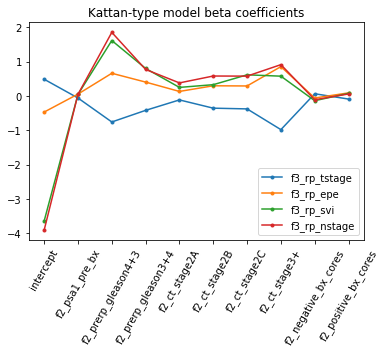

In [7]:
#Plot the Kattan-type beta coefficients

betas = ['intercept']
betas.extend(ListInputs('MSK'))

plt.figure()
for outcome in ListOutcomes('MSK'):
    plt.plot(betas, GetMSKCoef(outcome),marker='.', label=outcome)
    x = plt.gca().xaxis
    
    # rotate the tick labels for the x axis
for item in x.get_ticklabels():
    item.set_rotation(60)
plt.title('Kattan-type model beta coefficients')
plt.legend(loc='best')


## Main for Kattan

Summary statistics for outcomes:  
pT3+: 0.37435897435897436 ; Organ confined disease:  0.6256410256410256 
EPE:  0.3711340206185567 
SVI:  0.0693196405648267 
pN+:  0.04190751445086705
************
 F3_RP_TSTAGE 
************
Imputation:  False
f3_rp_tstage predicted mean:  0.4413949823903834


MSK classifier for f3_rp_tstage

Accuracy:  0.5807127882599581 
No. of 1s predicted:  506 . Number of zeros predicted:  925 
Confusion matrix:
 [[428 103]
 [497 403]]
              precision    recall  f1-score   support

           0       0.46      0.81      0.59       531
           1       0.80      0.45      0.57       900

   micro avg       0.58      0.58      0.58      1431
   macro avg       0.63      0.63      0.58      1431
weighted avg       0.67      0.58      0.58      1431

************
 F3_RP_EPE 
************
Imputation:  False
f3_rp_epe predicted mean:  0.5421530703790258


MSK classifier for f3_rp_epe

Accuracy:  0.600843288826423 
No. of 1s predicted:  876 . Number of zeros 

f3_rp_tstage    LogisticRegression(C=1.0, class_weight=None, d...
f3_rp_epe       LogisticRegression(C=1.0, class_weight=None, d...
f3_rp_svi       LogisticRegression(C=1.0, class_weight=None, d...
f3_rp_nstage    LogisticRegression(C=1.0, class_weight=None, d...
dtype: object

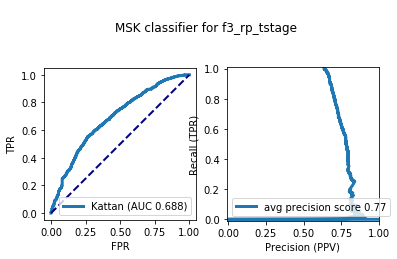

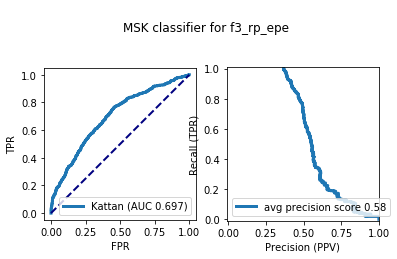

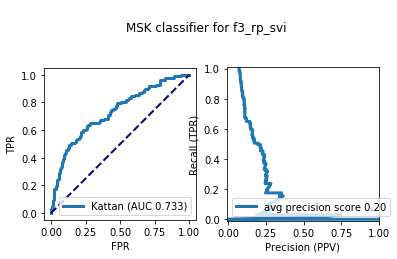

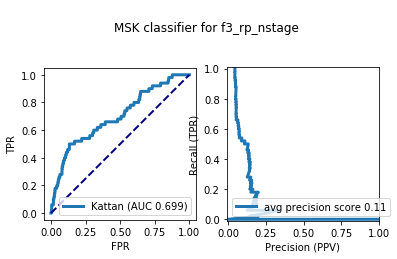

In [8]:
impute=False
debug=False

#mdl_name = 'MSK' #model to use
#mdl_var = 'MSK' #variables to use

input_file = 'c:/Users/'+UserFolder()+'/Box Sync/Prostate Pathology/DATA_2017-10-15_work_HZ_JK.csv'
    
df_raw = pd.read_csv(open(input_file), header = 0, parse_dates = True, index_col='record_id')

print('\nBefore pre-processing: ') if debug else ''
DatasetSummary(df_raw) if debug else ''

df_XY_msk = PreProcess(df_raw, 'MSK', 'MSK')

print('\nAfter pre-processing: ') if debug else ''
DatasetSummary(df_XY_msk) if debug else ''
PrintUnique(df_XY_msk) if debug else ''

#for storage of 4 models for 4 different f3 outcomes
mdl_msk = pd.Series(index=ListOutcomes('MSK'))
#eval_msk = pd.Series(index=ListOutcomes('MSK')) #, columns=['predict_proba', 'decision_function'])

for outcome in ListOutcomes('MSK'):
    print('************\n',outcome.upper(),'\n************')
    
    #create limited DataFrame df_Xy with only inputs per ListInputs('MSK') and output per outcome
    df_Xy = pd.concat([ df_XY_msk[ListInputs('MSK')],df_XY_msk[[outcome]] ], axis='columns')  
    
    df_Xy = HandleMissingData(df_Xy)
    
    print('Imputation: ',impute)
    print('\nShape: ',df_Xy.shape, ', \nMissing inputs: \n', df_Xy.isnull().sum()) if debug else ''
    display(mdl_var+' data after imputation: ',df_Xy.head()) if debug else ''

    #run Kattan model and return performance metrics df_eval and created model
    df_eval, mdl_msk.loc[outcome] = RunKattan(df_Xy, 'MSK', outcome)

    print(outcome+' predicted mean: ', df_eval.describe().loc['mean','predict_proba'])
    
    #Run model evaluation functions
    RunModelEval(mdl_msk.loc[outcome], 
                 df_Xy[ListInputs('MSK')], df_Xy[outcome], 
                 title='\nMSK classifier for '+outcome, 
                 metrics='ERP', 
                 PRC_thresh_on='predict_proba')

display(mdl_msk)
    

In [10]:
df_XY_msk.dtypes

f2_psa1_pre_bx          float64
f2_prerp_gleason4+3        bool
f2_prerp_gleason3+4        bool
f2_ct_stage2A              bool
f2_ct_stage2B              bool
f2_ct_stage2C              bool
f2_ct_stage3+           float64
f2_negative_bx_cores    float64
f2_positive_bx_cores    float64
f3_rp_tstage              int64
f3_rp_svi               float64
f3_rp_nstage            float64
f3_rp_epe               float64
dtype: object

# Random Forest
__Guides__
1. Tuning RF in Python Pt 1: https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd
2. Tuning RF in Python Pt 2: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
3. Feature selection in RF: https://blog.datadive.net/selecting-good-features-part-iii-random-forests/
4. Unbiased RF: https://link.springer.com/article/10.1186%2F1471-2105-8-25

__To do__
- port over to H2O due to issues with OHE (https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)

__Pseudocode__

for each outcome:

    X_, X, Y_, Y_ train_test_split()
    set aside test set
    train RF model using ONLY vars in MSK model
    train RF model using ALL vars +/- feature selection
    show training metrics
    test RF model using ONLY vars in MSK model
    test RF model using ALL vars +/- feature selection
    show testing metrics

## RF functions

In [13]:
'''
AUC

************
Loop 19, random_state: 28514, F3_RP_TSTAGE 
************
Test set AUC:  0.7825903885021335
Test set avg precision score:  0.840572770136994
Grid best param. (max. AUC):  {'max_depth': 60, 'max_features': 11, 'min_samples_leaf': 20, 'n_estimators': 500}
Grid best score (AUC):  0.7065745909797466

************
Loop 7, random_state: 88554, F3_RP_EPE 
************
Test set AUC:  0.7859925474254743
Test set avg precision score:  0.6934057036948443
Grid best param. (max. AUC):  {'max_depth': 40, 'max_features': 6, 'min_samples_leaf': 20, 'n_estimators': 500}
Grid best score (AUC):  0.7081612573536047
************

************
Loop 7, random_state: 88554, F3_RP_SVI 
************
Test set AUC:  0.8385878991939598
Test set avg precision score:  0.26469550013828447
Grid best param. (max. AUC):  {'max_depth': 20, 'max_features': 6, 'min_samples_leaf': 20, 'n_estimators': 500}
Grid best score (AUC):  0.759947442564341

************
Loop 4, random_state: 23177, F3_RP_NSTAGE 
************
Test set AUC:  0.8670212765957447
Test set avg precision score:  0.14476947357206615
Grid best param. (max. AUC):  {'max_depth': 20, 'max_features': 9, 'min_samples_leaf': 40, 'n_estimators': 500}
Grid best score (AUC):  0.709810230357428

'''

args = {'max_depth': None, 'max_features': 9, 'min_samples_leaf': 20, 'n_estimators': 200}

def GetArgs(outcome='f3_rp_tstage',scoring='AUC'):
    #returns dict of args that can be unpacked using **args in function call
    #parameter arguments were obtained via GridSearchCV
    if scoring is 'AUC':
        if outcome is 'f3_rp_tstage':
            return {'max_depth': 60, 'max_features': 11, 'min_samples_leaf': 20, 'n_estimators': 500}
        if outcome is 'f3_rp_epe':
            return {'max_depth': 40, 'max_features': 6, 'min_samples_leaf': 20, 'n_estimators': 500}
        if outcome is 'f3_rp_svi':
            return {'max_depth': 20, 'max_features': 6, 'min_samples_leaf': 20, 'n_estimators': 500}
        if outcome is 'f3_rp_nstage':
            return {'max_depth': 20, 'max_features': 9, 'min_samples_leaf': 40, 'n_estimators': 500}

def RunRandomForest(df, outcome='f3_rp_tstage', random_state=0):
    #print('************\n',outcome.upper(),'\n************')
    X = InputsOnly(df)
    y = df[outcome]
        
    #Split data into training & test set
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size = 0.2, random_state=random_state) #stratify=y
    
    #Run models
    rf = (RandomForestClassifier(**GetArgs(outcome, scoring='AUC'), class_weight='balanced', random_state=random_state)
          .fit(X_train,y_train))
    
    #RunModelEval(rf, X_train, y_train, 'RF training for '+outcome, metrics='ERP', PRC_thresh_on='predict_proba')
    RunModelEval(rf, X_valid, y_valid, 'RF testing for '+outcome, metrics='ERP', PRC_thresh_on='predict_proba')

    fpr, tpr, thresholds = roc_curve(y_valid, rf.predict_proba(X_valid)[:,1])
    
    return rf, pd.DataFrame(data={'fpr':fpr,'tpr':tpr,'thresholds':thresholds})

#rf, ROC = RunRandomForest(CombineSides(ImputeDataFrame(df_XY)), outcome)
#rf.estimators_
#rf.get_params()


## CombineSides

Combine left and right sides to increase power as left/right does not hold particular significance

__To do__
- attempt to have ALL binary variables to avoid bias


In [14]:
if debug:
    df = df_XY.copy()
    df['f2_locat_bx_cores_base'] = CombineRules(df['f2_locat_bx_cores___1'], df['f2_locat_bx_cores___4'])
    display(pd.concat([df['f2_locat_bx_cores_base'], df_XY['f2_locat_bx_cores___1'], df_XY['f2_locat_bx_cores___4']],axis='columns').head())
    display(pd.get_dummies(df['f2_locat_bx_cores_base']).head())
    
def CombineSides(df_in):

    def CombineBxCores(sideL, sideR):
        bilat_pos  = np.logical_and(sideL  , sideR  ) #both sides == 1
        unilat_pos = np.logical_xor(sideL  , sideR  ) #one sides  == 1
        negative   = np.logical_and(1-sideL, 1-sideR) #both sides == 0

        output = pd.Series(index=sideL.index)
        output.loc[bilat_pos] = 'bilat'
        output.loc[unilat_pos] = 'unilat'
        output.loc[negative] = 'neg'
        return output
    
    def CombinePNI_PIN(sideL, sideR):
    #if 1,1 then bilateral. If 1,2, then unilateral. If 1,3, then unilateral.
    #if 2,2 then negative. If 2,3, then negative
    #if 3,3 then unknown
        bilat_pos  = np.logical_and(sideL==1, sideR==1)
        negative   = np.logical_and(sideL==2, sideR==2) #both sides negative
        unknown    = np.logical_and(sideL==3, sideR==3) #both sides unknown
        
        output = pd.Series(data='unilat', index=sideL.index) #default is unilat
        output.loc[bilat_pos]  ='bilat'
        output.loc[negative]   ='neg'
        output.loc[unknown]    ='unk'
        return output
        
    df = df_in.copy()
    
    #Combine f2_locat_bx_cores_(base/mid/apex) var which describe location of biopsy cores
    # if both sides, then bilat. If 1 side only, then unilat. If neither side, then neg. 
    
    #New method: Bilat/unilat/none for base/mid/apex 
    df['f2_locat_bx_cores_base']=CombineBxCores(df['f2_locat_bx_cores___1'], df['f2_locat_bx_cores___4']) 
    df['f2_locat_bx_cores_mid'] =CombineBxCores(df['f2_locat_bx_cores___2'], df['f2_locat_bx_cores___5'])
    df['f2_locat_bx_cores_apex']=CombineBxCores(df['f2_locat_bx_cores___3'], df['f2_locat_bx_cores___6'])
    
    #Combine f2_gleason_(l/r/)(base/mid/apex) vars to describe
    df['f2_gleason_base'] = np.max(df[['f2_gleason_lbase','f2_gleason_rbase']].fillna(0),axis=1).astype(int)
    df['f2_gleason_mid']  = np.max(df[['f2_gleason_lmid','f2_gleason_rmid']].fillna(0),axis=1).astype(int)
    df['f2_gleason_apex'] = np.max(df[['f2_gleason_lapex','f2_gleason_rapex']].fillna(0),axis=1).astype(int)

    #Combine f2_pni_(l/r)(base/mid/apex)_pos perineural invasion positivity
    #Combine f2_pin_(l/r)(base/mid/apex)_pos prostatic intraepithelial neoplasia positivity

    df['f2_pni_base_pos'] = CombinePNI_PIN(df['f2_pni_lbase_pos'],df['f2_pni_rbase_pos'])
    df['f2_pni_mid_pos']  = CombinePNI_PIN(df['f2_pni_lmid_pos'] ,df['f2_pni_rmid_pos'])
    df['f2_pni_apex_pos'] = CombinePNI_PIN(df['f2_pni_lapex_pos'],df['f2_pni_rapex_pos'])
    
    df['f2_pin_base_pos'] = CombinePNI_PIN(df['f2_pin_lbase_pos'],df['f2_pin_rbase_pos'])
    df['f2_pin_mid_pos']  = CombinePNI_PIN(df['f2_pin_lmid_pos'] ,df['f2_pin_rmid_pos'])
    df['f2_pin_apex_pos'] = CombinePNI_PIN(df['f2_pin_lapex_pos'],df['f2_pin_rapex_pos'])

    #Convert above variables to dummies
    df = pd.get_dummies(df, columns=['f2_locat_bx_cores_base','f2_locat_bx_cores_mid','f2_locat_bx_cores_apex',
                                     'f2_gleason_base','f2_gleason_mid','f2_gleason_apex',
                                     'f2_pni_base_pos','f2_pni_mid_pos','f2_pni_apex_pos', 
                                     'f2_pin_base_pos','f2_pin_mid_pos','f2_pin_apex_pos'])
    
    #Combine f2_percent_(l/r/)(base/mid/apex)_pos positive cores using an average
    df['f2_percent_base_pos'] = np.mean(df[['f2_percent_lbase_pos','f2_percent_rbase_pos']].fillna(0),axis=1)
    df['f2_percent_mid_pos']  = np.mean(df[['f2_percent_lmid_pos' ,'f2_percent_rmid_pos' ]].fillna(0),axis=1)
    df['f2_percent_apex_pos'] = np.mean(df[['f2_percent_lapex_pos','f2_percent_rapex_pos']].fillna(0),axis=1)

    toDrop = [col for col in df_in.columns if np.any(['lbase' in col, 'rbase' in col,
                                                      'lmid'  in col, 'rmid'  in col,
                                                      'lapex' in col, 'rapex' in col,
                                                      'f2_locat_bx_cores___' in col])]

    return df.drop(toDrop, axis='columns')

#DatasetSummary(df_XY)
#PrintUnique(df_XY)
#CombineSides(df_XY).columns

## Main for RF

In [15]:
debug=False
import random

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#import h2o

mdl_name = 'RF' #model to use
mdl_var = 'RF' #variables to use

#Implement learning_curve
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py  

#Read cleaned file by Hong
input_file = 'c:/Users/'+UserFolder()+'/Box Sync/Prostate Pathology/DATA_2017-10-15_work_HZ_JK.csv'
df1_raw = pd.read_csv(open(input_file), header = 0, parse_dates = True, index_col='record_id')
df1_XY_msk = PreProcess(df1_raw, 'MSK', 'MSK', IO='I')

#Read "noisy" file that was not pre-cleaned
input_file2 = 'c:/Users/'+UserFolder()+'/Box Sync/Prostate Pathology/LNIncidenceInInterme_DATA_2017-10-04_1122.csv'
df2_raw = pd.read_csv(open(input_file2), header = 0, parse_dates = True, index_col='record_id')

#print('\nBefore pre-processing: ') if debug else ''
#DatasetSummary(df2_raw) if debug else ''

df2_XY_rf = PreProcess(df2_raw, 'RF', 'RF', IO='IO')

print('\nAfter pre-processing: ') if debug else ''
DatasetSummary(df2_XY_rf) if debug else ''
PrintUnique(df2_XY_rf) if debug else ''

df_XY_rf = pd.concat([df1_XY_msk, df2_XY_rf], axis='columns')

df_XY_rf = ImputeDataFrame(df_XY_rf, strategy='median')

df_XY_rf = CombineSides(df_XY_rf).sort_index(axis='columns') #combine L/R sides and sort columns due to column manipulation  

#df_XY_rf = OHE(df_XY_rf)

#df_XY.drop(['f2_percent_base_pos'],axis='columns',inplace=True)

Summary statistics for outcomes:  
pT3+: 0.37435897435897436 ; Organ confined disease:  0.6256410256410256 
EPE:  0.3711340206185567 
SVI:  0.0693196405648267 
pN+:  0.04190751445086705
Summary statistics for outcomes:  
pT3+: 0.37435897435897436 ; Organ confined disease:  0.6256410256410256 
EPE:  0.3711340206185567 
SVI:  0.0693196405648267 
pN+:  0.04190751445086705


## Calc stats using RF data

In [16]:
from scipy.stats import ttest_ind

C:\Users\jkang1\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\jkang1\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\jkang1\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\jkang1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


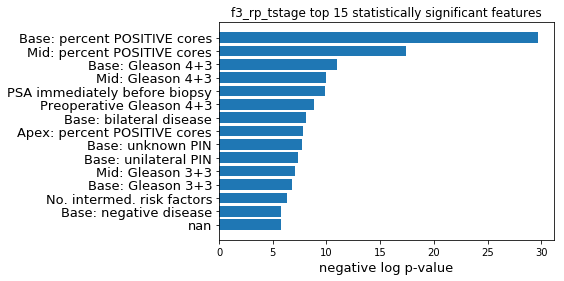

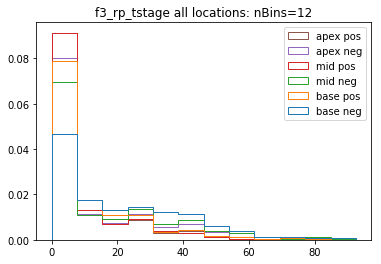

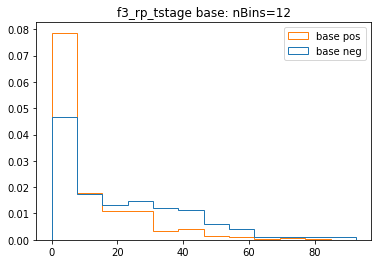

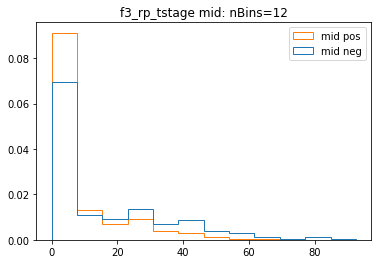

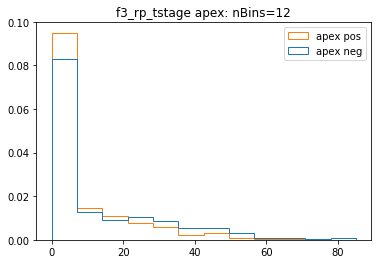

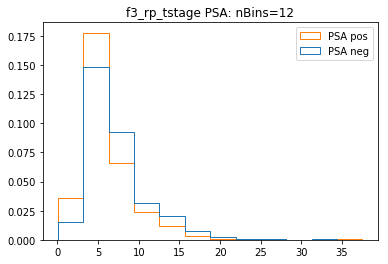

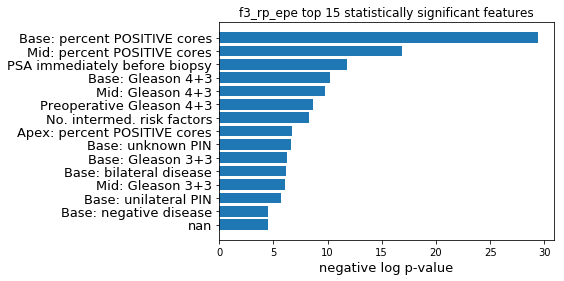

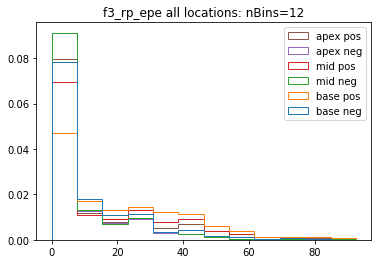

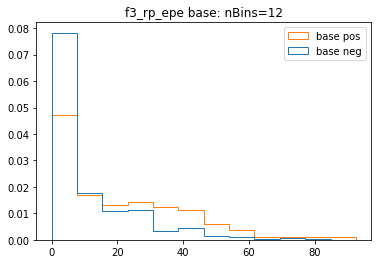

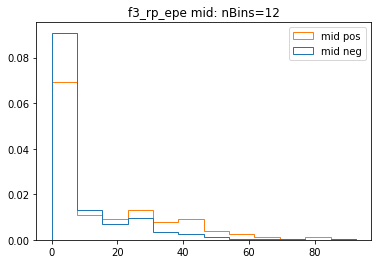

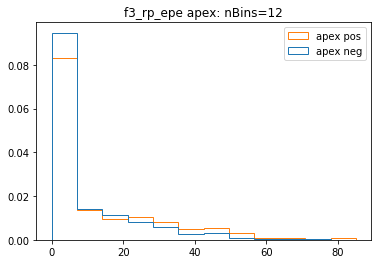

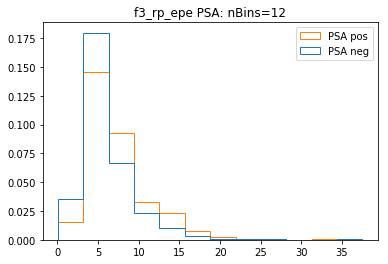

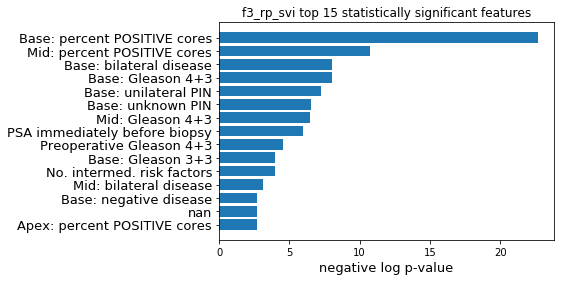

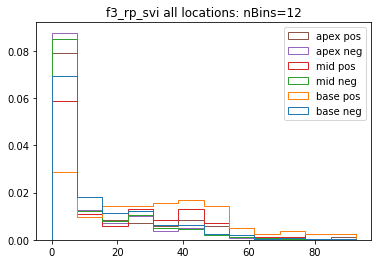

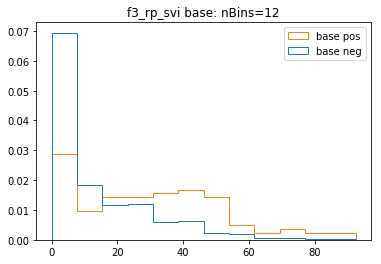

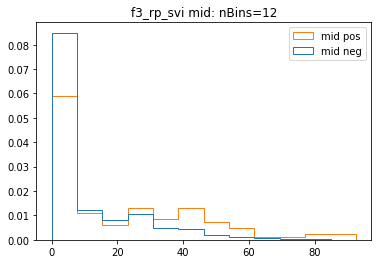

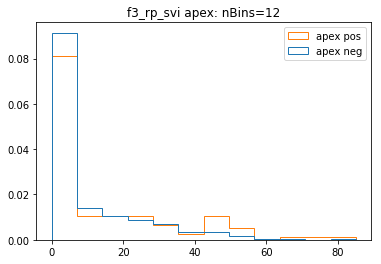

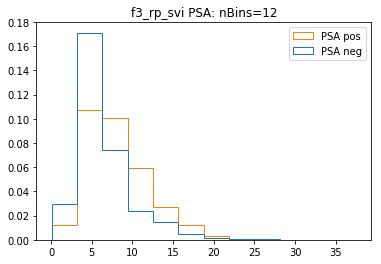

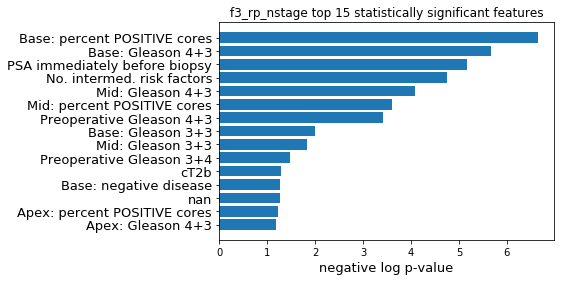

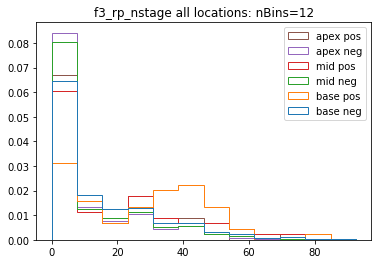

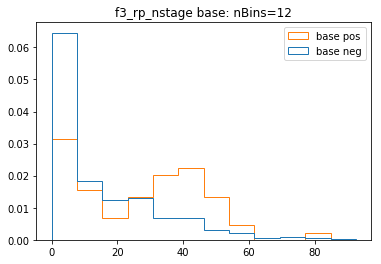

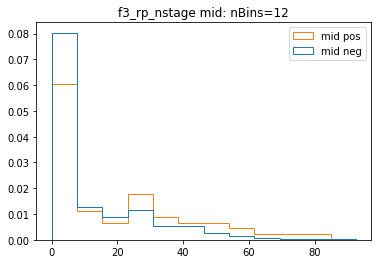

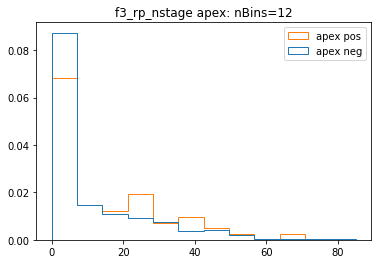

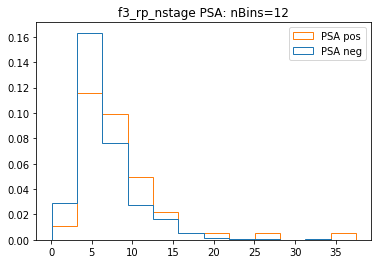

In [209]:
nFeats = 15 #number of most significant features to display when graphing

feat_dict = GetFeatureDict()

#Reformulate df_XY_rf. No imputation.
df_XY_rf = pd.concat([df1_XY_msk, df2_XY_rf], axis='columns')
df_XY_rf = CombineSides(df_XY_rf).sort_index(axis='columns') #combine L/R sides and sort columns due to column manipulation  

for outcome in ListOutcomes('RF'): 
    
    #df_neg & pos are from different individuals (either positive or negative outcome) and thus use ttest_independent
    df_neg = df_XY_rf.loc[ df_XY_rf[outcome]==0]
    df_pos = df_XY_rf.loc[ df_XY_rf[outcome]==1]

    #create dataframe with input columns that will store p-values. Shape will be (1,nInputs)
    p = pd.DataFrame(columns=InputsOnly(df_XY_rf).columns, dtype='float')
    
    #perform independent t-test to compare distributions of neg and pos outcomes for each input variable
    for col in InputsOnly(df_XY_rf):
        _, p.loc[0,col] = ttest_ind(df_neg[col],df_pos[col])

    #sort and calc neg log of p-values
    p = p.sort_values(by=0, axis=1)
    p = -np.log10(p)

    #Plot horizontal bar braph of top nFeats most statistically significant features
    plt.figure()
    plt.barh(range(nFeats), p.iloc[0,nFeats-1::-1],ecolor='#f46542') #first nFeats features in descending order
    plt.yticks(np.arange(nFeats), p.columns.map(feat_dict)[nFeats-1::-1], fontsize=13) #label y-axis with descriptive variables
    plt.xlabel('negative log p-value', fontsize=13)
    title = outcome +' top '+str(nFeats)+' statistically significant features'
    plt.title(title)
    
    #Plot histograms of pos & neg classes for all locations in same graph
    nBins = 12
    plt.figure()
    plt.hist([df_neg['f2_percent_base_pos'],df_pos['f2_percent_base_pos'],
              df_neg['f2_percent_mid_pos'] ,df_pos['f2_percent_mid_pos'],
              df_neg['f2_percent_apex_pos'],df_pos['f2_percent_apex_pos']],
             label=['base neg','base pos', 'mid neg', 'mid pos', 'apex neg', 'apex pos'], 
             bins=nBins, density=True, histtype='step')
    plt.legend(loc='best')
    plt.title(outcome+' all locations: nBins='+str(nBins))

    """
    plt.figure()
    for loc in ['f2_percent_mid_pos']:
        sns.distplot([df_neg[loc]], hist=True)
        sns.distplot([df_pos[loc]], hist=True)
    """
    #Plot histograms for location features in separate graphs
    plt.figure()
    plt.hist([df_neg['f2_percent_base_pos'], df_pos['f2_percent_base_pos']],
             label=['base neg', 'base pos'], density=True, histtype='step', bins=nBins)
    plt.legend(loc='best')
    plt.title(outcome+ ' base: nBins='+str(nBins))
    
    plt.figure()
    plt.hist([df_neg['f2_percent_mid_pos'], df_pos['f2_percent_mid_pos']],
             label=['mid neg', 'mid pos'], density=True, histtype='step', bins=nBins)
    plt.legend(loc='best')
    plt.title(outcome+ ' mid: nBins='+str(nBins))
    
    plt.figure()
    plt.hist([df_neg['f2_percent_apex_pos'], df_pos['f2_percent_apex_pos']],
             label=['apex neg', 'apex pos'], density=True, histtype='step', bins=nBins)
    plt.legend(loc='best')
    plt.title(outcome+ ' apex: nBins='+str(nBins))

    plt.figure()
    plt.hist([df_neg['f2_psa1_pre_bx'], df_pos['f2_psa1_pre_bx']],
             label=['PSA neg', 'PSA pos'], density=True, histtype='step', bins=nBins)
    plt.legend(loc='best')
    plt.title(outcome+ ' PSA: nBins='+str(nBins))

In [199]:
df_pos.shape

(58, 79)

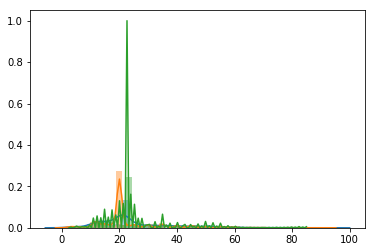

In [119]:
for loc in ['f2_percent_base_pos', 'f2_percent_mid_pos', 'f2_percent_apex_pos']:
    sns.distplot([df_neg[loc]], hist=True)
    sns.distplot([df_pos[loc]], hist=True)

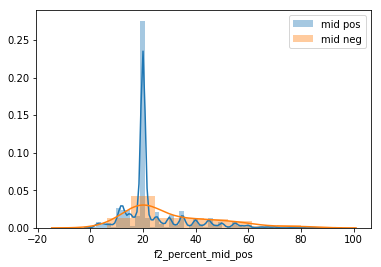

In [129]:
#sns.distplot(df_neg['f2_percent_base_pos'], hist=True, label='base pos'
#sns.distplot(df_pos['f2_percent_base_pos'], hist=True, label='base neg')
sns.distplot(df_neg['f2_percent_mid_pos'], hist=True, label='mid pos')
sns.distplot(df_pos['f2_percent_mid_pos'], hist=True, label='mid neg')
plt.legend(loc='best')


RF testing for f3_rp_tstage

Accuracy:  0.6923076923076923 
No. of 1s predicted:  177.0 . Number of zeros predicted:  135.0 
Confusion matrix:
 [[ 78  39]
 [ 57 138]]
             precision    recall  f1-score   support

          0       0.58      0.67      0.62       117
          1       0.78      0.71      0.74       195

avg / total       0.70      0.69      0.70       312

mean AUC:  0.7378040762656147


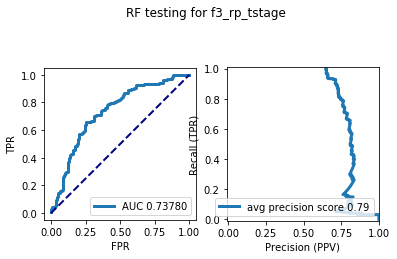

In [11]:
# perform RF for single outcomes

AUCs = []

outcome = 'f3_rp_tstage'
for loops in np.arange(1,2):
    rf, ROC = RunRandomForest(df_XY_rf, outcome, random_state=random.randint(1,9999999))
    AUCs.append(auc(ROC['fpr'],ROC['tpr']))
    
print('mean AUC: ', np.mean(AUCs))

# Plot AUC with CI

Adopted from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

In [941]:
def toy_example_stdev_v_sem():
    #according to stack exchange, this does not calculate 95% CI correctly 
    #https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
    a = np.arange(10,14)
    sem = sp.stats.sem(a)
    mean = np.mean(a)
    std = np.std(a)
    sqrt = np.sqrt(len(a))
    display(a, mean, sem, [mean-2*sem, mean+2*sem], [mean-(2*std/sqrt), mean+(2*std/sqrt)])
    
toy_example_stdev_v_sem()

array([10, 11, 12, 13])

11.5

0.6454972243679028

[10.209005551264195, 12.790994448735805]

[10.381966011250105, 12.618033988749895]

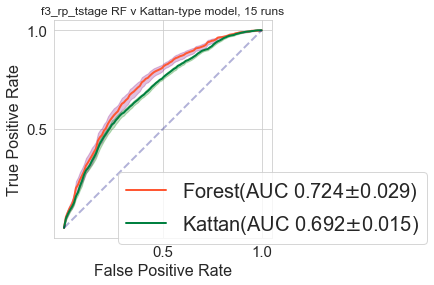

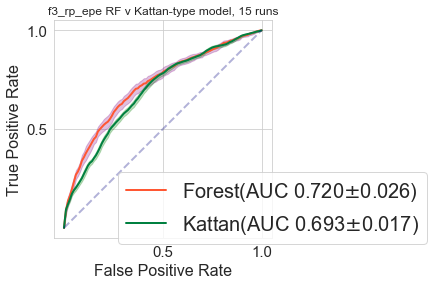

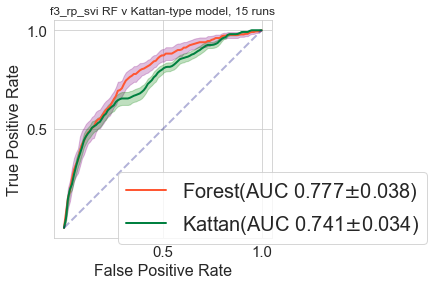

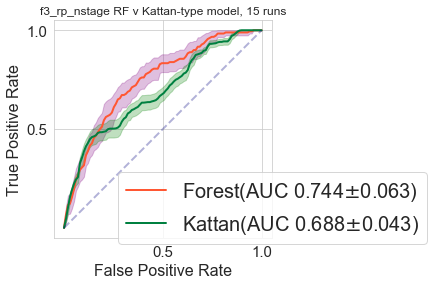

In [34]:
doSave=False

from sklearn.model_selection import StratifiedKFold, ShuffleSplit
import scipy as sp
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import resample

def CalcAUC_CV(df_XY, outcome, clf, cv = ShuffleSplit(n_splits=100,test_size=0.2)):

    X = InputsOnly(df_XY)
    y = df_XY[[outcome]]

    #clf = rf

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100) #points to interpolate linearly for specified fpr & tpr

    idx = 0

    for train, test in cv.split(X, y):
        X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train].values.ravel(), y.iloc[test].values.ravel()    

        probas_ = clf.fit(X_train, y_train).predict_proba(X_test)

        #Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0 # -1 refers to last appended interpolation and 0 refers to the initial value. Set this to 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.3f)' % (idx, roc_auc))
        idx += 1
    return tprs, aucs

#cv options:  cv = StratifiedKFold(n_splits = k), ShuffleSplit(n_splits = k, test_size = 0.2)
#tprs, aucs = CalcAUC_CV(df_XY_rf, rf)

def CalcInterpolated_TPR(sr_ROCs): 
    #df_in contains a column denoted by col_ROC where each element is a list of 3 arrays: tpr, fpr, and thresolds (not used)
    
    #create a Series object and make it Object type so it can store lists
    output = pd.Series(index=sr_ROCs.index, name='tpr_interp').astype(object)
    
    mean_fpr = np.linspace(0, 1, 100) #points to interpolate linearly for specified fpr & tpr

    for idx in sr_ROCs.index:
        fpr, tpr = sr_ROCs.loc[idx][0], sr_ROCs.loc[idx][1] 
        tpr_interp = sp.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0 #set initial TPR to 0
        output.loc[idx] = tpr_interp

    return output

def BootstrapROCs(y_true, y_score, n_bootstraps=15, rng_seed=1):
    #adopt from https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals
    rng = np.random.RandomState(rng_seed)
    
    #output = pd.DataFrame(index=range(n_bootstraps),columns=['bootstrap_ROC'])
    #create a Series object and make it Object type so it can store lists
    output = pd.Series(index=range(n_bootstraps), name='bootstrap_ROC').astype(object)
    bootstrapped_aucs = []
    
    #convert y_true from Series to array
    y_true = y_true.values if type(y_true) is pd.core.series.Series else y_true

    for idx in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        rand_idx = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[rand_idx])) <2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue
        
        tpr, fpr, thresholds = roc_curve(y_true[rand_idx], y_score[rand_idx])
        output.loc[idx] = [tpr, fpr, thresholds]
        
        #also track AUC
        auc = roc_auc_score(y_true[rand_idx], y_score[rand_idx])
        bootstrapped_aucs.append(auc)
        print("Bootstrap #{} ROC area: {:0.3f}".format(idx + 1, auc)) if debug else ''
        
    return output, bootstrapped_aucs

def PlotROCs(tprs, aucs, mdl='Forest', color_ROC='red', color_Err='purple', useSEM=True, label_Err=False):

    #plots averaged ROC with std devs
    mean_tpr = np.mean(tprs, axis=0) #means of indiv points across multiple folds
    mean_fpr = np.linspace(0, 1, len(mean_tpr)) #interpolated tprs (Y-values) assumes some no. pts linearly spaced from 0-1 as as X-values
    
    mean_tpr[-1] = 1.0 #set last data points to be 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color=color_ROC,
             label=mdl+r'(AUC %0.3f$\pm$%0.3f)' % (mean_auc, std_auc),
             lw=2, alpha=1)

    #plot standard deviations
    std_tpr = np.std(tprs, axis=0)
    sem2_tpr = np.std(tprs, axis=0)*1.96 / np.sqrt(tprs.shape[0]-1)
    
    if useSEM:
        tprs_upper = np.minimum(mean_tpr + sem2_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - sem2_tpr, 0)
        label = mdl+r'$\pm$ 2 std err' if label_Err else ''
    else:
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        label = mdl+r'$\pm$1 SD' if label_Err else ''
        
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color_Err, alpha=.25, label=label)

#Load data file of cross validated parameter tuning 
ROC_tuneCV = pd.read_pickle('181015_ROC_tuneCV')

#Append interpolated TPRs 
ROC_tuneCV = pd.concat([ROC_tuneCV, 
                        CalcInterpolated_TPR(ROC_tuneCV['test_ROC'])], axis='columns')

palette =  sns.diverging_palette(220, 20, n=9)
sns.set_palette(palette)
sns.set_style("whitegrid")

for outcome in ListOutcomes('MSK'):

    """Plot ROC of RF model"""
    
    #store outcome specific interpolated TPR and AUCs for all repetitions
    tprs = np.vstack( ROC_tuneCV.loc[ROC_tuneCV['outcome']==outcome, 'tpr_interp'] )
    aucs = np.vstack( ROC_tuneCV.loc[ROC_tuneCV['outcome']==outcome, 'test_AUC'] )

    PlotROCs(tprs,aucs, mdl='Forest', color_ROC='#FF5733', color_Err='purple', useSEM=True)
    
    """Plot ROC of MSK model"""
    
    df_Xy = pd.concat([ df_XY_msk[ListInputs('MSK')],df_XY_msk[[outcome]] ], axis='columns')  
    df_Xy = HandleMissingData(df_Xy, impute)
 
    y_true = df_Xy[outcome]
    y_proba = mdl_msk.loc[outcome].predict_proba(InputsOnly(df_Xy))[:,1]
    
    msk_ROCs, aucs = BootstrapROCs(y_true, y_proba, n_bootstraps=15)
    
    tprs = np.vstack(CalcInterpolated_TPR(msk_ROCs))
    
    PlotROCs(tprs, aucs,mdl='Kattan', color_ROC='#008040', color_Err = 'green', useSEM=True)
    #ShowROC(mdl_msk.loc[outcome], InputsOnly(df_Xy), df_Xy[outcome])
    
    #plot straight line denoting dummy classifier denoting chance
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy', alpha=.3)
    
    #Format the plots
    plt.gca().set_aspect('equal')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xticks([0.5, 1.0], fontsize=15)
    plt.yticks([0.5, 1.0], fontsize=15)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.legend(loc='best', bbox_to_anchor=(0.25, 0.35), prop={'size': 20})

    title = outcome+' RF v Kattan-type model, '+str(tprs.shape[0])+' runs'
    plt.title(title)
    plt.savefig(title) if doSave else ''
    plt.show()
    

In [32]:
tprs = np.vstack(CalcInterpolated_TPR(msk_ROCs))
tprs

array([[0.        , 0.03278689, 0.03278689, ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.02325581, 0.1627907 , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.07272727, 0.18181818, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.        , 0.04545455, 0.04545455, ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.08510638, 0.08510638, ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.09259259, 0.11111111, ..., 1.        , 1.        ,
        1.        ]])

In [1181]:
aucs = np.vstack(ROC_tuneCV.loc[ROC_tuneCV['outcome']==outcome, 'test_AUC'])
aucs

array([[0.61083333],
       [0.77444444],
       [0.7175    ],
       [0.83694444],
       [0.65277778],
       [0.70833333],
       [0.77055556],
       [0.69916667],
       [0.81416667],
       [0.79      ],
       [0.78416667],
       [0.77194444],
       [0.67777778],
       [0.81722222],
       [0.73277778]])

In [33]:
y_proba.dtype

dtype('float64')

In [1111]:
roc_curve(y_true, y_proba)

(array([0.        , 0.00188324, 0.00188324, 0.00376648, 0.00376648,
        0.00564972, 0.00564972, 0.00753296, 0.00753296, 0.0094162 ,
        0.0094162 , 0.01129944, 0.01129944, 0.01318267, 0.01318267,
        0.01506591, 0.01506591, 0.01694915, 0.01694915, 0.01883239,
        0.01883239, 0.02071563, 0.02071563, 0.02259887, 0.02259887,
        0.02448211, 0.02448211, 0.02448211, 0.02448211, 0.02824859,
        0.02824859, 0.03201507, 0.03201507, 0.03389831, 0.03389831,
        0.03766478, 0.03766478, 0.03954802, 0.03954802, 0.04143126,
        0.04143126, 0.0433145 , 0.0433145 , 0.04519774, 0.04519774,
        0.04708098, 0.04708098, 0.04896422, 0.04896422, 0.05084746,
        0.05084746, 0.0527307 , 0.0527307 , 0.05461394, 0.05461394,
        0.05649718, 0.05649718, 0.06026365, 0.06026365, 0.06214689,
        0.06214689, 0.06591337, 0.06591337, 0.06967985, 0.06967985,
        0.07156309, 0.07156309, 0.07344633, 0.07344633, 0.07532957,
        0.07532957, 0.07721281, 0.07721281, 0.07

In [ ]:
# perform RF for all outcomes

for outcome in ListOutcomes('RF'):
    print('************\n',outcome.upper(),'\n************')

    AUCs = []

    for loops in np.arange(1,2):
        rf, ROC = RunRandomForest(ImputeDataFrame(df_XY_rf, strategy='median'), 'RF', outcome, random_state=random.randint(1,999))
        AUCs.append(auc(ROC['fpr'],ROC['tpr']))
    #print(outcome+': '+str(np.mean(AUCs)))
        
print(np.mean(AUCs))

# Feature importance

In [ ]:
def GetFeatureImportanceSorted(rf, names, outcome):
    df_FeatImp = pd.DataFrame(data={
        'feature':np.array(names)[np.argsort(rf.feature_importances_)][::-1], #in descending importance 
        'importance': np.sort(rf.feature_importances_)[::-1] #in descending importance
    })
    df_FeatImp.index.name = outcome+' rank'
    return df_FeatImp

nFeats = 10
df_FI = GetFeatureImportanceSorted(rf, df_XY_rf.columns,outcome)
display(df_FI) if debug else ''
plt.barh(range(nFeats), df_FI.loc[range(nFeats),'importance'][::-1])
plt.yticks(np.arange(nFeats), df_FI.loc[range(nFeats), 'feature'][::-1])
plt.xlabel('feature importance')
plt.ylabel('feature name')
plt.title('Top '+str(nFeats)+' feature importances for '+outcome)

C:\Users\jkang1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


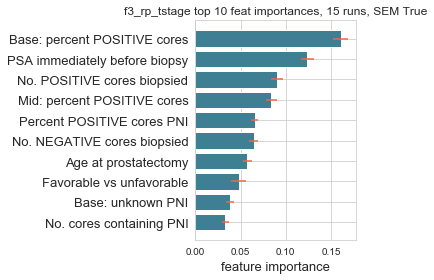

C:\Users\jkang1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


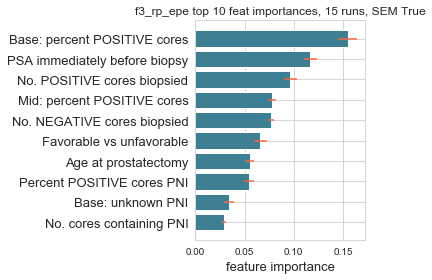

C:\Users\jkang1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


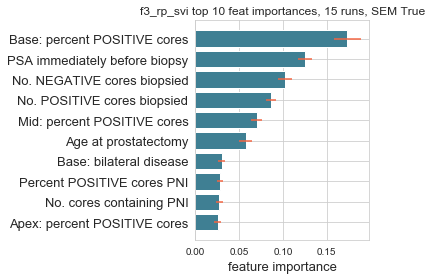

C:\Users\jkang1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


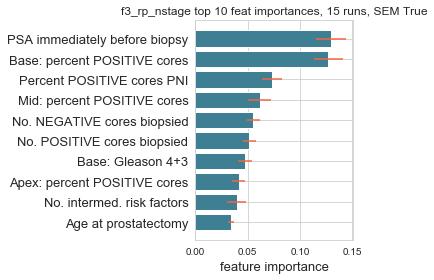

In [88]:
from matplotlib import rcParams

#Set to True to save figures without having Y-axis cut off
rcParams.update({'figure.autolayout': True}) 

def AppendFeatureImportanceMean(df_CV, outcome, feat_names):
    
    #slice dataframe to have have outcome of interest and the best modelin the repetition
    df_best_mdl = df_CV.loc[df_CV['outcome']==outcome, 'best_mdl']
   
    #to store feature importances for each repetition
    df_FIs = pd.DataFrame(index=feat_names)
    df_FIs.index.name = 'feat_names'

    #each column will store all feature importances in that repetition
    for idx in df_best_mdl.index:    
        df_FIs['importance_'+str(idx)] = df_best_mdl.loc[idx].best_estimator_.feature_importances_
        
    #calc mean & std
    df_FIs['mean'], df_FIs['std'] = np.mean(df_FIs,axis=1), np.std(df_FIs,axis=1)
    
    return df_FIs

feat_dict = GetFeatureDict()

nFeats = 10
plotSEM=True
nLoops = np.max(ROC_tuneCV['loop'])+1

for outcome in ListOutcomes('RF'):
    
    #Calculate feature importances for all repetitions of outcome
    df_FIs = AppendFeatureImportanceMean(ROC_tuneCV, outcome, InputsOnly(df_XY_rf).columns)
    df_FIs.sort_values(by=['mean'], ascending=False, inplace=True)
    
    #set color scheme
    palette =  sns.diverging_palette(220, 20, n=9)
    sns.set_palette(palette)
    
    #plot
    xerr = df_FIs['std'][nFeats-1::-1]
    xerr = 1.96*xerr/np.sqrt(nLoops-1) if plotSEM else xerr
    
    plt.figure()
    plt.barh(range(nFeats), df_FIs['mean'][nFeats-1::-1], xerr=xerr, ecolor='#f46542') #first nFeats features in ascending order
    plt.yticks(np.arange(nFeats), df_FIs.index.map(feat_dict)[nFeats-1::-1], fontsize=13)
    plt.xlabel('feature importance', fontsize=13)
    #plt.ylabel('feature name')
    title = outcome+' top '+str(nFeats)+' feat importances, '+str(tprs.shape[0])+' runs, SEM '+str(plotSEM)
    plt.title(title)
    plt.savefig(title) if doSave else ''

In [89]:
df_FIs

,importance_3,importance_7,importance_11,importance_15,importance_19,importance_23,importance_27,importance_31,importance_35,importance_39,importance_43,importance_47,importance_51,importance_55,importance_59,mean,std
feat_names,,,,,,,,,,,,,,,,,
f2_psa1_pre_bx,0.123608,0.122296,0.144511,0.104029,0.139977,1.336820e-01,0.206156,0.117687,1.353961e-01,0.108432,9.119442e-02,0.100030,0.145536,0.158950,0.107998,1.292988e-01,2.769385e-02
f2_percent_base_pos,0.130859,0.158941,0.080817,0.112380,0.127654,9.419386e-02,0.147533,0.176226,1.141532e-01,0.137705,8.219344e-02,0.141447,0.147211,0.134757,0.115826,1.267931e-01,2.632118e-02
f2_calc_percent_pni,0.107413,0.072823,0.042383,0.091111,0.082924,7.945972e-02,0.081156,0.072613,5.171767e-02,0.058767,5.193603e-02,0.084618,0.067643,0.101144,0.057733,7.356277e-02,1.814726e-02
f2_percent_mid_pos,0.052174,0.048577,0.058420,0.067203,0.039960,4.678345e-02,0.047876,0.113856,4.754797e-02,0.065262,5.459405e-02,0.073369,0.104641,0.039730,0.060578,6.137134e-02,2.103385e-02
f2_negative_bx_cores,0.057268,0.029696,0.047476,0.060649,0.044404,4.648457e-02,0.052927,0.050303,6.095098e-02,0.065385,5.396794e-02,0.049296,0.058126,0.074579,0.077073,5.523906e-02,1.155107e-02
f2_positive_bx_cores,0.068232,0.041598,0.042554,0.050620,0.034040,5.546534e-02,0.046130,0.071837,4.254023e-02,0.067129,4.397228e-02,0.045941,0.045597,0.064518,0.054519,5.164612e-02,1.109663e-02
f2_gleason_base_3,0.042507,0.048593,0.031090,0.053355,0.059711,6.314387e-02,0.042698,0.047292,6.039060e-02,0.061494,3.042295e-02,0.070296,0.036429,0.029764,0.038852,4.773591e-02,1.273043e-02
f2_percent_apex_pos,0.025180,0.029057,0.043348,0.055150,0.021568,4.058570e-02,0.065831,0.030366,3.799524e-02,0.052877,3.942239e-02,0.039473,0.055507,0.051330,0.034998,4.151255e-02,1.213877e-02
f2_intermed_factors,0.047730,0.045977,0.098173,0.038842,0.048365,3.179812e-02,0.040547,0.021178,4.058875e-02,0.023327,3.483305e-02,0.025668,0.028098,0.032748,0.035475,3.955652e-02,1.769162e-02


# AUC CV RF parameter tuning

In [170]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, precision_score
import random


nLoops = 15

ROC_tuneCV = pd.DataFrame(columns=['loop', 'random_state', 'outcome', 'best_mdl', 'train_best_AUC', 'train_best_params', 'test_AUC', 'test_ROC','test_avg_precision_score'], index=np.arange(0,nLoops*4))

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100) #points to interpolate linearly for specified fpr & tpr

idx = 0


for loop in np.arange(nLoops):

    random_state = random.randint(1,99999)
    
    for outcome in ListOutcomes('RF'):
        print('************\nLoop '+str(loop)+', random_state: '+str(random_state)+', '+outcome.upper(),'\n************')
     
        clf = RandomForestClassifier()
        
        X, y= InputsOnly(df_XY_rf), df_XY_rf.loc[:, outcome]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                            stratify=y, random_state=random_state)

        grid_values = { 'max_features':np.arange(6,14),'n_estimators':[500], 'min_samples_leaf': [1,5,20, 40], 'max_depth':[None, 5, 20, 40, 60]}

        # optimize AUC over grid parameters
        grid_clf_auc = GridSearchCV(clf, param_grid = grid_values, cv=5, scoring = 'roc_auc')
        grid_clf_auc.fit(X_train, y_train)
        
        #confidence (probability) of y_prediction
        y_pred_proba = grid_clf_auc.predict_proba(X_test)[:,1] #probability of positive class 

        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        
        ROC_tuneCV.iloc[idx] = [loop, random_state, outcome, grid_clf_auc,
                                grid_clf_auc.best_score_, 
                                grid_clf_auc.best_params_, 
                                roc_auc_score(y_test, y_pred_proba),
                                [fpr, tpr, thresholds],
                                average_precision_score(y_test, y_pred_proba, average='macro')] #estimation of area under precision-recall curve

        print('Test set AUC: ', ROC_tuneCV.loc[idx,'test_AUC']) # roc_auc_score(y_test, grid_clf_auc.predict(X_test)))
        print('Test set avg precision score: ',  ROC_tuneCV.loc[idx,'test_avg_precision_score']) #average_precision_score(y_test, grid_clf_AUC.predict_proba(X_test)[:,1],average='macro'))
        print('Grid best param. (max. AUC): ', ROC_tuneCV.loc[idx,'train_best_params']) #grid_clf_auc.best_params_)
        print('Grid best score (AUC): ', ROC_tuneCV.loc[idx,'train_best_AUC']) #grid_clf_auc.best_score_)
        
        idx = idx + 1

        #    rf, ROC = RunRandomForest(ImputeDataFrame(df_XY, strategy='median'), 'RF', outcome, random_state=random.randint(1,999))
        #    AUCs.append(auc(ROC['fpr'],ROC['tpr']))
        #print(outcome+': '+str(np.mean(AUCs)))
        
#ROC_tuneCV.to_pickle('****_ROC_tuneCV')        

************
Loop 0, random_state: 67551, F3_RP_TSTAGE 
************
Test set AUC:  0.7655928117466578
Test set avg precision score:  0.8117064889770375
Grid best param. (max. AUC):  {'max_depth': 60, 'max_features': 13, 'min_samples_leaf': 20, 'n_estimators': 500}
Grid best score (AUC):  0.7122344407012838
************
Loop 0, random_state: 67551, F3_RP_EPE 
************
Test set AUC:  0.7077907746634298
Test set avg precision score:  0.6121113941060669
Grid best param. (max. AUC):  {'max_depth': 40, 'max_features': 12, 'min_samples_leaf': 20, 'n_estimators': 500}
Grid best score (AUC):  0.7381355591174594
************
Loop 0, random_state: 67551, F3_RP_SVI 
************
Test set AUC:  0.7562695924764891
Test set avg precision score:  0.16886640340059783
Grid best param. (max. AUC):  {'max_depth': 40, 'max_features': 9, 'min_samples_leaf': 20, 'n_estimators': 500}
Grid best score (AUC):  0.7798432448336293
************
Loop 0, random_state: 67551, F3_RP_NSTAGE 
************
Test set A

Test set AUC:  0.7705555555555555
Test set avg precision score:  0.18824911132332756
Grid best param. (max. AUC):  {'max_depth': None, 'max_features': 12, 'min_samples_leaf': 40, 'n_estimators': 500}
Grid best score (AUC):  0.7713642981375087
************
Loop 7, random_state: 34475, F3_RP_TSTAGE 
************
Test set AUC:  0.7332456717072102
Test set avg precision score:  0.8072456636914662
Grid best param. (max. AUC):  {'max_depth': 40, 'max_features': 11, 'min_samples_leaf': 20, 'n_estimators': 500}
Grid best score (AUC):  0.721848414146935
************
Loop 7, random_state: 34475, F3_RP_EPE 
************
Test set AUC:  0.7143235488854557
Test set avg precision score:  0.587928766451759
Grid best param. (max. AUC):  {'max_depth': 40, 'max_features': 10, 'min_samples_leaf': 5, 'n_estimators': 500}
Grid best score (AUC):  0.7242865594234258
************
Loop 7, random_state: 34475, F3_RP_SVI 
************
Test set AUC:  0.7741379310344827
Test set avg precision score:  0.228623243266

Test set AUC:  0.7236677115987462
Test set avg precision score:  0.2714451236650479
Grid best param. (max. AUC):  {'max_depth': 60, 'max_features': 13, 'min_samples_leaf': 20, 'n_estimators': 500}
Grid best score (AUC):  0.7966455369130508
************
Loop 13, random_state: 48279, F3_RP_NSTAGE 
************
Test set AUC:  0.8172222222222222
Test set avg precision score:  0.1612926000190793
Grid best param. (max. AUC):  {'max_depth': 5, 'max_features': 9, 'min_samples_leaf': 40, 'n_estimators': 500}
Grid best score (AUC):  0.7225654500404889
************
Loop 14, random_state: 1013, F3_RP_TSTAGE 
************
Test set AUC:  0.741661187815034
Test set avg precision score:  0.8134667657032533
Grid best param. (max. AUC):  {'max_depth': 40, 'max_features': 11, 'min_samples_leaf': 20, 'n_estimators': 500}
Grid best score (AUC):  0.7259754017457556
************
Loop 14, random_state: 1013, F3_RP_EPE 
************
Test set AUC:  0.7536526153167071
Test set avg precision score:  0.64059820674

In [171]:
ROC_tuneCV.to_csv('181015_ROC_tuneCV.csv')

# SVC

In [ ]:
"""
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

outcome = 'f3_rp_tstage'

# again, making this a binary problem with 'digit 1' as positive class 
# and 'not 1' as negative class
clf = SVC(kernel='linear', C=1)


# accuracy is the default scoring metric
print('Cross-validation (accuracy)', cross_val_score(clf, X, y, cv=5))
# use AUC as scoring metric
print('Cross-validation (AUC)', cross_val_score(clf, X, y, cv=5, scoring = 'roc_auc'))
# use recall as scoring metric
print('Cross-validation (recall)', cross_val_score(clf, X, y, cv=5, scoring = 'recall'))

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = SVC(kernel='rbf')
grid_values = {'gamma': [0.00001, 0.001, 0.01, 0.05, 0.1, 1, 10]}

# default metric to optimize over grid parameters: accuracy
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values)
grid_clf_acc.fit(X_train, y_train)
y_decision_fn_scores_acc = grid_clf_acc.decision_function(X_test) 

print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc.best_score_)

# alternative metric to optimize over grid parameters: AUC
grid_clf_auc = GridSearchCV(clf, param_grid = grid_values, scoring = 'roc_auc')
grid_clf_auc.fit(X_train, y_train)
y_decision_fn_scores_auc = grid_clf_auc.decision_function(X_test) 

print('Test set AUC: ', roc_auc_score(y_test, y_decision_fn_scores_auc))
print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
print('Grid best score (AUC): ', grid_clf_auc.best_score_)
"""

# F1 CV RF parameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, average_precision_score
import random

nLoops = 10
F1_tuneCV = pd.DataFrame(columns=['loop', 'random_state', 'outcome', 'best_mdl', 'train_best_F1', 'train_best_params', 'test_F1', 'test_avg_precision_score'], index=np.arange(0,nLoops*4))

idx = 0

for loop in np.arange(1,nLoops):

    random_state = random.randint(1,99999)
    
    for outcome in ['f3_rp_tstage', 'f3_rp_epe']:
        print('************\nLoop '+str(loop)+', random_state: '+str(random_state)+', '+outcome.upper(),'\n************')
        clf = RandomForestClassifier()
        X, y= ImputeDataFrame(df_XY).loc[:, ListInputs('RF')], ImputeDataFrame(df_XY)[outcome]

        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=random_state)

        grid_values = { 'max_features':np.arange(6,14),'n_estimators':[500], 'min_samples_leaf': [1,5,20, 40], 'max_depth':[None, 5, 20, 40, 60]}

        # optimize AUC over grid parameters
        grid_clf_f1 = GridSearchCV(clf, param_grid = grid_values, cv=5, scoring = 'f1')
        grid_clf_f1.fit(X_train, y_train)

        F1_tuneCV.iloc[idx] = [loop, random_state, outcome, grid_clf_f1,
                               grid_clf_f1.best_score_, 
                               grid_clf_f1.best_params_, 
                               f1_score(y_test, grid_clf_f1.predict(X_test)),
                               average_precision_score(y_test, grid_clf_f1.predict_proba(X_test)[:,1],average='macro')]
        
        #display(F1_tuneCV.iloc[idx])

        print('Test set F1: ', F1_tuneCV.loc[idx,'test_F1']) # f1_score(y_test, grid_clf_f1.predict(X_test)))
        print('Test set avg precision score: ',  F1_tuneCV.loc[idx,'test_avg_precision_score']) #average_precision_score(y_test, grid_clf_f1.predict_proba(X_test)[:,1],average='macro'))
        print('Grid best parameter (max. F1): ', F1_tuneCV.loc[idx,'train_best_params']) #grid_clf_f1.best_params_)
        print('Grid best score (F1): ',  F1_tuneCV.loc[idx,'train_best_F1']) #grid_clf_f1.best_score_)
        
        idx = idx + 1

        #    rf, ROC = RunRandomForest(ImputeDataFrame(df_XY, strategy='median'), 'RF', outcome, random_state=random.randint(1,999))
        #    AUCs.append(auc(ROC['fpr'],ROC['tpr']))
        #print(outcome+': '+str(np.mean(AUCs)))
        
        

In [1311]:
def TestImputation(): #imputation test code
    from sklearn.preprocessing import Imputer
    imp = Imputer(missing_values='NaN', strategy='median', axis=0)
    temp2 = np.array([[1,2], [np.nan, 3], [7,np.nan]])
    imp.fit(temp2)
    display(temp2, imp.statistics_, imp.transform(temp2))
    
TestImputation()

array([[ 1.,  2.],
       [nan,  3.],
       [ 7., nan]])

array([4. , 2.5])

array([[1. , 2. ],
       [4. , 3. ],
       [7. , 2.5]])

# Data visualization

In [ ]:
def CategoricalPlot(df):

    fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(13,13))
    sns.despine(left=True)
    axs = [ax1, ax2, ax3, ax4]
    #"""
    for idx in np.arange(0,len(axs)):
        outcome=ListOutcomes('RF')[idx]
        sns.catplot(y='f2_psa1_pre_bx', x='f2_ct_stage', kind='boxen',hue=outcome, hue_order=list(GetDictValues(outcome).values()),
                    data=df.sort_values('f2_ct_stage',axis='rows').replace({outcome: GetDictValues(outcome),'f2_ct_stage':GetDictValues('f2_ct_stage')}), ax=axs[idx])
        axs[idx].set_title(outcome)

    return
    #"""
CategoricalPlot(df_XY_rf)

In [1317]:
def InspectData_PairPlot(df_XY, mdl_var='MSK'):
    #consider for categorical data: https://seaborn.pydata.org/tutorial/categorical.html
        
    if 'MSK' in mdl_var:
        inputs = ['f2_psa1_pre_bx','f2_prerp_gleason' ,'f2_ct_stage', 'f2_positive_bx_cores', 'f2_negative_bx_cores']
        #df = ConvertOutput(df, mdl_var)
        
        for outcome in df_XY[GetOutputs(mdl_var)]:
            #print('\n', outcome)
            sns.pairplot( df_XY.dropna(axis='rows').replace({outcome:GetDictValues(outcome)}), hue=outcome, vars=inputs, dropna=True, diag_kind='kde', markers='.')
        #sns.pairplot(df_Y)
    return df


temp=InspectData_PairPlot(df_XY_rf,mdl_var='MSK')

AttributeError: 'str' object has no attribute 'columns'

In [ ]:
temp = {'f2_psa1_pre_bx':['12'],
     'f2_psa2_pre_rp':['<54'],
     'f2_psa3_pre_rp':['>21'],
     'f2_psa4_pre_rp':['<9'],
     'f3_rp_psa_nadir_value':['UNDETECTABLE']}
df2 = pd.DataFrame(temp, columns=cols)
df2

def SetPSAGreaterThan(df):
    cols = ['f2_psa1_pre_bx',
         'f2_psa2_pre_rp',
         'f2_psa3_pre_rp',
         'f2_psa4_pre_rp',
         'f3_rp_psa_nadir_value']
    df[cols]=df[cols].applymap(lambda x: x.split('>')[1] if '>' in x else x)
    
    return df
SetPSAGreaterThan(df)

In [ ]:
def SetPSALessThan(df):
    cols = ['f2_psa1_pre_bx',
         'f2_psa2_pre_rp',
         'f2_psa3_pre_rp',
         'f2_psa4_pre_rp',
         'f3_rp_psa_nadir_value']
    
    df[cols]=df[cols].applymap(lambda x: pd.to_numeric(x.split('<')[1])/2 if '<' in x else x)
    #    df[cols]=df[cols].applymap(lambda x: x.split('<')[1]/2 if '<' in x else x)
    return df
SetPSALessThan(df)

In [ ]:
#PRE-PROCESSING: convert certain columns to numeric

df[['f2_prost_volume_bx','f2_total_bx_cores','f2_positive_bx_cores','f2_negative_bx_cores','f2_percent_lbase_pos','f2_percent_lmid_pos','f2_percent_lapex_pos','f2_percent_rbase_pos','f2_percent_rmid_pos','f2_percent_rapex_pos','f2_percent_other_pos','f2_pni_number_cores','f2_pin_number_cores','f2_psa1_pre_bx','f2_psa2_pre_rp','f2_psa3_pre_rp','f2_psa4_pre_rp']]=df[['f2_prost_volume_bx','f2_total_bx_cores','f2_positive_bx_cores','f2_negative_bx_cores','f2_percent_lbase_pos','f2_percent_lmid_pos','f2_percent_lapex_pos','f2_percent_rbase_pos','f2_percent_rmid_pos','f2_percent_rapex_pos','f2_percent_other_pos','f2_pni_number_cores','f2_pin_number_cores','f2_psa1_pre_bx','f2_psa2_pre_rp','f2_psa3_pre_rp','f2_psa4_pre_rp']].apply(pd.to_numeric, errors = 'coerce')


#Convert imported races from initial 7 to final 4 categories: Unknown, Black, Asian, White
lookup = {"f1_race_imported": {"** NO DESCRIPTION **": "Unknown",
                               "african american":"Black",
                               "AMERICAN INDIAN OR ALASKA NATI":"Unknown",
                               "ASIAN":"Asian",
                               "ASIAN INDIAN":"Asian",
                               "black":"Black",
                               "BLACK OR AFRICAN AMERICAN": "Black",
                               "black/african":"Black",
                               "Black/African American":"Black",
                               "OTHER":"Unknown",
                               "PATIENT DECLINED":"Unknown",
                               "TAHITIAN":"Asian",
                               "UNKNOWN":"Unknown",
                               "unknown":"Unknown",
                               "WHITE":"White",
                               "white":"White"}}
df.replace(lookup, inplace=True)

df['f1_race_imported'].astype('category')

#One Hot Encoding to make multiple category values into into binary values
df = pd.get_dummies(df, columns=["f1_urologist","f1_race_imported"])

#df.sort_values('record_id')

#write array to excel spreadsheet
#writer = pd.ExcelWriter('path_to_file.xls', engine='xlwt')
df.to_excel('path_to_file.xls')

In [ ]:
#CHOOSE OUTPUT
output = 'f3_rp_margins'

temp = df[output]
#temp.head()

#Drop other outputs
df.drop([col for col in df.columns if 'f3' in col], axis=1, inplace=True)

#Create concatenate chosen output
df = pd.concat([df,temp], axis = 1)

In [ ]:
##PRE-PROCESSING: convert dates into relative time

#converts date strings into datetime64 format
df['f1_diagnosis_date']  = pd.to_datetime(df['f1_diagnosis_date'])
df['f1_prostatect_date'] = pd.to_datetime(df['f1_prostatect_date'])
df['f2_date_psa1_pre_bx'] = pd.to_datetime(df['f2_date_psa1_pre_bx'])
df['f2_date_psa2_pre_rp'] = pd.to_datetime(df['f2_date_psa2_pre_rp'])
df['f2_date_psa3_pre_rp'] = pd.to_datetime(df['f2_date_psa3_pre_rp'])
df['f2_date_psa4_pre_rp'] = pd.to_datetime(df['f2_date_psa4_pre_rp'])
#df['f3_rp_psa_nadir_date'] = pd.to_datetime(df['f3_rp_psa_nadir_date'])

#confirm datetime format
pd.options.display.max_rows = 999
#df.dtypes

In [ ]:
#Convert prostatectomy date to "days from diagnosis"
temp = df['f1_prostatect_date'] - df['f1_diagnosis_date']
df.rename(columns={'f1_prostatect_date':'f1_prostatect_timedelta'}, inplace=True)
df['f1_prostatect_timedelta'] = temp

#df[(df['date'])]

In [ ]:
pd.concat([df['f2_date_psa1_pre_bx'],df['f2_date_psa2_pre_rp'], df['f2_date_psa3_pre_rp'], df['f2_date_psa4_pre_rp']], axis=1)
#df.loc[0,'f1_diagnosis_date']

In [ ]:
#Calculate PSA velocity

#Remove PSAs above 2015: may not be necessary

#Find PSA range of 1 year
#https://stackoverflow.com/questions/29370057/select-dataframe-rows-between-two-dates

#timept1 = df[ (df['f2_date_psa2_pre_rp'] > df['f2_date_psa1_pre_bx'] - pd.Timedelta(days=365)) &
# (df['f2_date_psa2_pre_rp'] < df['f2_date_psa1_pre_bx'])]

withinDx1y_bool1 = (df['f2_date_psa2_pre_rp'] > df['f2_date_psa1_pre_bx'] - pd.Timedelta(days=365)) & (df['f2_date_psa2_pre_rp'] < df['f2_date_psa1_pre_bx'])
withinDx1y_bool2 = (df['f2_date_psa3_pre_rp'] > df['f2_date_psa1_pre_bx'] - pd.Timedelta(days=365)) & (df['f2_date_psa3_pre_rp'] < df['f2_date_psa1_pre_bx'])
withinDx1y_bool3 = (df['f2_date_psa4_pre_rp'] > df['f2_date_psa1_pre_bx'] - pd.Timedelta(days=365)) & (df['f2_date_psa4_pre_rp'] < df['f2_date_psa1_pre_bx'])

boolMask = pd.concat([withinDx1y_bool1, withinDx1y_bool2, withinDx1y_bool3], axis = 1)
boolMask.head(10)


#df.loc[0,'f2_psa1_pre_bx'].plot(marker='o', ylim=[0,20])
#plt.ylabel("PSA")

#df['psa1_']
#regr = linear_model.LinearRegression()
#regr.fit(df['f2_psa'])

#calculate PSA double time


#remove diagnosis date
#df.dtypes

In [ ]:
boolMask.dtypes

In [ ]:

#PSA = df[['f2_psa1_pre_bx', 'f2_psa2_pre_rp', 'f2_psa3_pre_rp', 'f2_psa4_pre_rp']]
PSA = df[['f2_psa1_pre_bx', 'f2_psa2_pre_rp', 'f2_psa3_pre_rp']]

PSA.dtypes

In [ ]:
x = PSA>5
boolMask.dtypes
#PSA.mask(PSA > 5)
#PSA2.head()
#PSA2

In [ ]:
nsInYear = 3.1556952E+16;

times = df['f2_date_psa1_pre_bx'] - df['f2_date_psa2_pre_rp']
times = times.astype(int)/nsInYear
times.head()
#df['f2_date_psa1_pre_bx'].astype(int)
#df['f2_date_psa1_pre_bx'].astype('timedelta64[D]')


#from sklearn import linear_model

#lr = linear_model.LinearRegression().fit(df['f2_date_psa1_pre_bx'], df['f2_psa1_pre_bx'])

#from statsmodels.regression.linear_model import OLS

#type(df['f2_date_psa1_pre_bx'])
#model = pd.stats.ols(y=df['f2_psa1_pre_bx'], x=df['f2_date_psa1_pre_bx'])

In [ ]:
#PRE-PROCESSING: organize features
df.reindex_axis(sorted(df.columns), axis=1)
#sorted(df.columns)

In [ ]:
#write array to excel spreadsheet
df.to_excel('path_to_file.xls')

In [ ]:
##PRE-PROCESSING: normalization
from sklearn import preprocessing

#If SVM, normalize around zero
df_scaled = preprocessing.scale(df)

In [ ]:
##PRE-PROCESSING
df.dtypes